In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import tensorflow as tf
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.optimizers import SGD
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
train_folder = '/content/gdrive/MyDrive/Projects/flower_category_prediction/flower_dataset/train'
labels = os.listdir(train_folder)
num_classes = len(set(labels))
image_size = 224
batch_size=24
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical'
    )

Found 1190 images belonging to 17 classes.


In [4]:
train_folder = '/content/gdrive/MyDrive/Projects/flower_category_prediction/flower_dataset/train'
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    horizontal_flip=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    validation_split=0.2)# set validation split

train_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='training'
    )
validation_generator = data_generator.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical',
    subset='validation'
    )

Found 952 images belonging to 17 classes.
Found 238 images belonging to 17 classes.


In [5]:
test_folder = '/content/gdrive/MyDrive/Projects/flower_category_prediction/flower_dataset/test'
test_generator = data_generator.flow_from_directory(
    test_folder,
    target_size=(image_size, image_size),
    batch_size=24,
    class_mode='categorical'
    )

Found 170 images belonging to 17 classes.


In [6]:
test_generator.image_shape

(224, 224, 3)

In [7]:
# Create model
# model = Sequential()
base_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')
base_model.summary()
print("Number of layers in trainable: ", len(base_model.trainable_variables))
# base_input = base_model.layers[0].input
# base_output = base_model.layers[-2].output
# final_output = Dense(num_classes, activation='softmax')(base_output)
# customized_model = Model(inputs = base_input, outputs = final_output)


# model.add(base_model)
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(.5))
# model.add(BatchNormalization())
# model.add(Dense(num_classes, activation='softmax'))

#Do not train first layer (ResNet) as it is already pre-trained
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

#Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
__________________________

In [8]:
base_input = base_model.layers[0].input
base_output = base_model.layers[-24].output
avg = GlobalAveragePooling2D()(base_output)
final_output = Dense(num_classes, activation='softmax')(avg)
model = Model(inputs = base_input, outputs = final_output)
model.summary()
print("Number of layers in trainable: ", len(model.trainable_variables))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
# Compile model
sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print("Number of layers in trainable: ", len(model.trainable_variables))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 5
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction


cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/content/gdrive/MyDrive/Projects/flower_category_prediction/customized_best.hdf5',
                                  monitor = 'val_loss',
                                  save_best_only = True,
                                  mode = 'auto')
start = datetime.datetime.now()
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=10,
    epochs=NUM_EPOCHS,
    callbacks=[cb_checkpointer, cb_early_stopper])

end = datetime.datetime.now()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 124s 12s/step - loss: 3.2848 - accuracy: 0.3222 - val_loss: 3.3461 - val_accuracy: 0.4580
Epoch 2/100
10/10 [==============================] - 84s 8s/step - loss: 1.0743 - accuracy: 0.7607 - val_loss: 3.3467 - val_accuracy: 0.5714
Epoch 3/100
10/10 [==============================] - 76s 8s/step - loss: 0.6804 - accuracy: 0.8399 - val_loss: 2.7522 - val_accuracy: 0.6723
Epoch 4/100
10/10 [==============================] - 77s 8s/step - loss: 1.0575 - accuracy: 0.7876 - val_loss: 3.6499 - val_accuracy: 0.6513
Epoch 5/100
10/10 [==============================] - 75s 8s/step - loss: 0.5030 - accuracy: 0.8499 - val_loss: 2.0483 - val_accuracy: 0.7479
Epoch 6/100
10/10 [==============================] - 75s 8s/step - loss: 0.3773 - accuracy: 0.9053 - val_loss: 1.2204 - val_accuracy: 0.8151
Epoch 7/100
10/10 [==============================] - 74s 8s/step - loss: 0.3569 - accuracy: 0.9090 - val_loss: 2.3590 - val_accuracy: 0.6723
Epoch 8/100

In [11]:
print('Execution time : ', end-start)

Execution time :  0:29:36.007860


In [12]:
model.load_weights("/content/gdrive/MyDrive/Projects/flower_category_prediction/customized_best.hdf5")

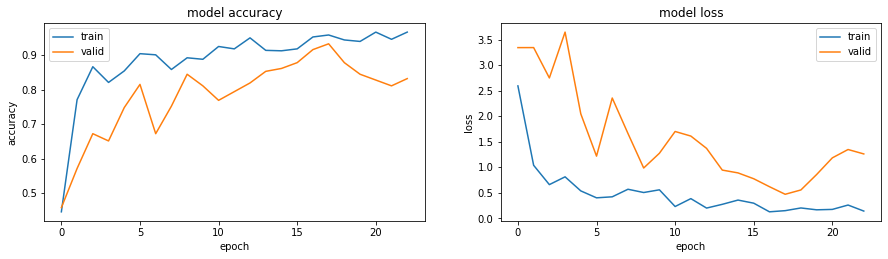

In [13]:
plt.figure(1, figsize = (15,8)) 
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()

In [14]:
train_steps = train_generator.n // batch_size
val_steps = validation_generator.n // batch_size
test_steps = test_generator.n // batch_size
# evaluate performance on train, val & test datasets
loss, acc = model.evaluate_generator(train_generator, steps=train_steps, verbose=1, workers=3)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(validation_generator, steps=val_steps, verbose=1, workers=3)
print('Validation data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_generator(test_generator, steps=test_steps, verbose=1, workers=3)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


39/39 [==============================] - 142s 4s/step - loss: 0.3553 - accuracy: 0.9252
Training data  -> loss: 0.355, acc: 0.925
9/9 [==============================] - 33s 3s/step - loss: 0.5129 - accuracy: 0.9074
Validation data -> loss: 0.513, acc: 0.907
7/7 [==============================] - 27s 4s/step - loss: 2.5204 - accuracy: 0.6786
Testing data   -> loss: 2.520, acc: 0.679


In [15]:
def predict_category(img_file):
    img = load_img(img_file, target_size=(image_size, image_size))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    # classes = model.predict_classes(x)
    y_proba=model.predict(x)
    return y_proba.argmax()

In [16]:
import os
classes_dict = train_generator.class_indices
test_img_path = '/content/gdrive/MyDrive/Projects/flower_category_prediction/flower_dataset/test'
test_img_dirs = os.listdir(test_img_path)

x_test, y_test, y_pred, test_img_paths = [], [], [], []
for dir in test_img_dirs:
    img_file_names = os.listdir(f'{test_img_path}/{dir}')
    for img_file in img_file_names:
        test_img_paths.append(f'{dir}/{img_file}')
        img_path = f'{test_img_path}/{dir}/{img_file}'
        # print(img_path)
        x_test.append(load_img(img_path))
        category = predict_category(img_path)
        # print(category)
        pred = list(classes_dict.keys())[list(classes_dict.values()).index(category)]
        y_pred.append(pred)
        y_test.append(dir)

sunflower/image_0793.jpg
Actual : sunflower, Predicted : windflower


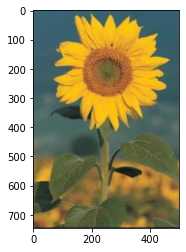

sunflower/image_0800.jpg
Actual : sunflower, Predicted : daisy


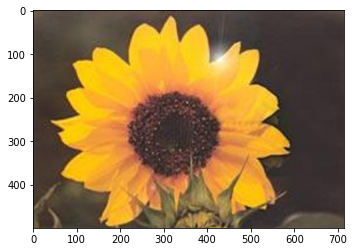

sunflower/image_0796.jpg
Actual : sunflower, Predicted : iris


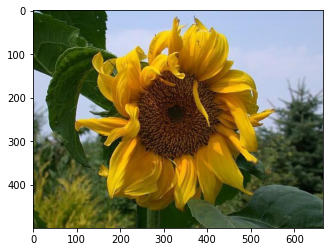

In [17]:
def plot_wrong_predictions(x_test, y_test, y_pred, test_img_paths, n = 1):
    count = 0
    for input, prediction, actual, test_img_path in zip (x_test, y_pred, y_test, test_img_paths):
        if count < n:
            if prediction != actual:
                print(test_img_path)
                print(f'Actual : {actual}, Predicted : {prediction}')
                plt.imshow(input)
                plt.show()
                count+=1
plot_wrong_predictions(x_test, y_test, y_pred, test_img_paths, n = 3)